<a href="https://colab.research.google.com/github/mwithgod3952/Machine_Learning_Theory_jh/blob/master/Autoencode%EB%A5%BC_%ED%86%B5%ED%95%9C_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive; drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
imgs_dir = "/content/drive/MyDrive/pr_image_similarity_with_dense_net/train"
img_path_lst = os.listdir(imgs_dir)

In [ ]:
# for i in range(len(img_path_lst)):
#     new_name = f"row_{os.listdir(imgs_dir)[i].split('_')[0]}_{os.listdir(imgs_dir)[i]}"
#     os.rename(imgs_dir + "/" +  os.listdir(imgs_dir)[i], imgs_dir + "/" + new_name)

In [ ]:
img_path_lst = os.listdir(imgs_dir)
img_path_lst[-5: ]

['032fac6b9.jpg',
 '034b31ef4.jpg',
 '039533860.jpg',
 '03056d2b8.jpg',
 '034e5fe12.jpg']

In [ ]:
print("training data length : ", len(img_path_lst))

training data length :  25362


---

In [ ]:
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas.util.testing as tm

# Part of Visualization 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE

# Model Performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib

# Model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# i used only 2/3 pictures as training data just for testing
img_path_lst = img_path_lst[:int(len(img_path_lst)/100*1)]
len(img_path_lst)

253

In [ ]:
train_files, test_files = train_test_split(img_path_lst, test_size = 0.15)

In [ ]:
print("the length of train dataset", len(train_files), " / "
      "the length of test dataset", len(test_files))

the length of train dataset 215  / the length of test dataset 38


In [ ]:
train_files = pd.DataFrame(train_files, columns=['dir'])
test_files = pd.DataFrame(test_files, columns=['dir'])

# Make train, test csv files
train_files.to_csv('/content/drive/My Drive/train_file.csv')
test_files.to_csv('/content/drive/My Drive/test_file.csv')

# Import train, test csv files
train_files = pd.read_csv('/content/drive/MyDrive/train_file.csv')
test_files  = pd.read_csv('/content/drive/MyDrive/test_file.csv')

# Save the file path information to the list
train_files = list(train_files.iloc[:,1])
test_files = list(test_files.iloc[:,1])

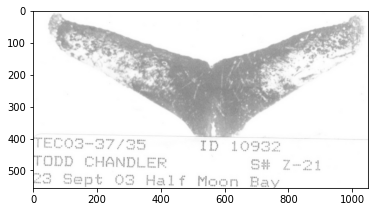

In [ ]:
img = cv2.imread('/content/drive/MyDrive/pr_image_similarity_with_dense_net/train/'+train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

***Image load***

In [ ]:
def image_to_array(file_array):
    global image_array, image_array_
    image_array = []
    for path in tqdm(file_array):
        img = cv2.imread('/content/drive/MyDrive/pr_image_similarity_with_dense_net/train/'+ path)
        time.sleep(1.5)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))

    image_array_ = image_array.copy()

    image_array_ = np.array(image_array_)
    image_array_ = image_array_.reshape(image_array_.shape[0], 224, 224, 3) 
    image_array_ = image_array_.astype('float32')
    image_array_ /= 255      
      
    return np.array(image_array_)

In [ ]:
train_data = image_to_array(train_files)

  0%|          | 0/215 [00:00<?, ?it/s]

In [ ]:
test_data = image_to_array(test_files)

  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
def AUEC_encoding_and_decoding():

    # -------------------------- Encoding Section
    model = Sequential(name='Conv_Autoencoder_Ml')
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3,3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
    # Regularizer : to avoid overfitting, apply penalties on layer parametrs / loss of L2 class = l2 * reduce_sum(square(0.001))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
    # padding='valid'
    model.add(MaxPooling2D(pool_size=(2,2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
    # -------------------------- Decoding Section
    model.add(Conv2D(512, kernel_size=(3,3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2,2), name='Decoding_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3,3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(UpSampling2D((2,2), name='Decoding_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
    model.add(UpSampling2D((2,2),name='Decoding_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
    model.add(UpSampling2D((2,2),name='Decoding_Upsamping2D_5'))
    # in this section i use the sigmoid function because, it is the last step to classify.
    model.add(Conv2D(3, kernel_size=(3,3), padding='same',activation='sigmoid',name='Decoding_Output'))

    return model

In [ ]:
model = AUEC_encoding_and_decoding()
model.summary()

Model: "Conv_Autoencoder_Ml"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None, 28, 28, 512

***Parameter Tuning***

In [ ]:
# 1) Optimization

mod_nm = ['Adagrad', 'Adam', 'RMSprop']
param  = [0.01, 0.001, 0.0001, 0.00001]

res = []

for y in [0,1,2]:

    res_ = []
    print(f'Selected optimizer : {mod_nm[y]}')

    for x in param:

        print(f'learning_rate : , {x}')
        model = AUEC_encoding_and_decoding()

        if y == 0:
            optimizer = Adagrad(learning_rate = x)
        elif y == 1:
            optimizer = Adam(learning_rate = x)
        elif y == 2:
            optimizer = RMSprop(learning_rate = x)    

        model.compile(optimizer=optimizer, loss='mse')
        model.fit(train_data, train_data, epochs=5, batch_size=32, validation_data=(test_data,test_data)) 
        res_.append(model.history.history)
        
    print()
    res.append(res_)        

Selected optimizer : Adagrad
learning_rate : , 0.01
Epoch 1/5
7/7 [==============================] - 215s 30s/step - loss: 2.2898 - val_loss: 2.3019
Epoch 2/5
7/7 [==============================] - 213s 30s/step - loss: 2.2876 - val_loss: 2.2997
Epoch 3/5
7/7 [==============================] - 212s 30s/step - loss: 2.2854 - val_loss: 2.2975
Epoch 4/5
7/7 [==============================] - 211s 30s/step - loss: 2.2833 - val_loss: 2.2954
Epoch 5/5
7/7 [==============================] - 212s 30s/step - loss: 2.2812 - val_loss: 2.2933
learning_rate : , 0.001
Epoch 1/5
7/7 [==============================] - 221s 31s/step - loss: 2.2893 - val_loss: 2.3026
Epoch 2/5
7/7 [==============================] - 215s 31s/step - loss: 2.2890 - val_loss: 2.3023
Epoch 3/5
7/7 [==============================] - 216s 31s/step - loss: 2.2888 - val_loss: 2.3021
Epoch 4/5
7/7 [==============================] - 215s 31s/step - loss: 2.2886 - val_loss: 2.3019
Epoch 5/5
7/7 [==============================] - 21

In [ ]:
plt.figure(figsize = (7, 3))

plt.plot(min_train, color = 'b', label = 'training')
plt.scatter(x=mod_nm, y=min_train, color = 'b', alpha = 0.7)

plt.title('Mininum Loss')
plt.ylabel('Loss')

plt.legend()
plt.show()

NameError: ignored

<Figure size 504x216 with 0 Axes>

In [ ]:
plt.figure( figsize = (25, 5) )

for i in range(4):
    plt.subplot(1,4, i+1)

    if i == 0:
        plt.plot(res[1][i]['loss'], color = 'b', alpha = 0.7, label = 'Training')
        plt.plot(res[1][i]['val_loss'], color='r', alpha = 0.5, label = 'Validation')

    else:
        plt.plot(res[1][i]['loss'], color = 'b', alpha = 0.7)
        plt.plot(res[1][i]['val_loss'], color='r', alpha = 0.5)

    plt.scatter(x=epochs, y=res[1][i]['loss'], color = 'b')
    plt.scatter(x=epochs, y=res[1][i]['val_loss'], color = 'r')

    plt.title(f'Optimizer : Adam, learning_rate : {param[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.show()

In [ ]:
optimizer = Adam(learning_rate=0.001) 
model = AUEC_encoding_and_decoding() 

model.compile(optimizer=optimizer, loss='mse') 

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, min_delta=0.0001) 
checkpoint = ModelCheckpoint('/content/drive/My Drive/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 

model.fit(train_data, train_data, epochs=35, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping, checkpoint])